In [15]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pprint import pprint
from cpymad.madx import Madx, TwissFailed

In [2]:
sys.path.append("../")
sys.path.append("../LOCOinPython/")
sys.path.append("../Tracking_with_imperfections/")

In [3]:
from LOCOinPython.file_loader.structure_loader import read_structure, collect_structure 
from LOCOinPython.numerical_model.imperfections import Imperfections 
from LOCOinPython.numerical_model.orbit_correction import OrbitCorrectionSVD
from LOCOinPython.numerical_model.response_matrix import run_madx
from LOCOinPython.numerical_model.lattice_correction import LatticeCorrection

In [6]:
def apply_kicks(madx, kicks_corrs, reversed=False) -> None:
    """
    Apply kicks of correctors.

    :param madx: Madx instance
    :param kicks_corrs: corr_name-kick_value dict
    :param reversed: whether to apply kicks with the opposite sign
    :return: None
    """
    if reversed:
        kicks_corrs["kick"]["Values"] *= -1
    for idx, corr in enumerate(kicks_corrs["kick"]["Knobs"]):
        madx.elements[corr].kick += kicks_corrs["kick"]["Values"][idx]

In [27]:
def get_optics(structure: dict, 
               aligns: dict = None, 
               old_aligns: dict = None, 
               kicks_corrs: dict = None, 
               closing: bool = False, 
               elems_for_closing: dict = None,
               save_etable: bool = False,
               file_to_save: str = None) -> dict:
    """
    Get optical functions, etc.

    :param structure: obtained from read_structure func
    :param aligns: imperfections
    :param old_aligns: preexisted imperfections
    :param kicks_corrs: corr_name-kick_value dict
    :param closing: whether to perform closing
    :param elems_for_closing: dict with elems to use as knobs in closing 
    :return: dict with optical functions, orbits, etc.
    """
    madx = Madx(stdout=False)
    madx.input("option, echo=false, warn=false, info=false, twiss_print=false;")
    collect_structure(structure, madx)
    Imperfections.add_to_model(madx, aligns)
    Imperfections.add_to_model(madx, old_aligns)

    if kicks_corrs:
        for corr_type, corr_list in kicks_corrs.items():
            for corr, kick_val in corr_list.items():
                madx.elements[corr].kick += kick_val

    if closing:
        kick_amplitude = 1e-3  # Adjust me
        grad_amplitude = 1e-2  # Adjust me
        verbosing_freq = 100  # Adjust me
        iteration = 0
        closed = False

        while not closed:
            kicks = (np.random.random(len(elems_for_closing["kick"]["Knobs"])) - 0.5) * kick_amplitude
            elems_for_closing["kick"]["Values"] = kicks
            k1 = (np.random.random(len(elems_for_closing["k1l"]["Knobs"])) - 0.5) * grad_amplitude
            elems_for_closing["k1l"]["Values"] = k1
            try:
                apply_kicks(madx, elems_for_closing)
                Imperfections.add_to_model(madx, elems_for_closing)

                madx.select('FLAG = Twiss', 'class = monitor')
                madx.twiss(table='twiss', centre=True)
                madx.input('select, flag = twiss, clear;')
                closed = True
            except TwissFailed:
                apply_kicks(madx, elems_for_closing, reversed=True)
                elems_for_closing["k1l"]["Values"] *= -1
                Imperfections.add_to_model(madx, elems_for_closing)
                iteration += 1
                if iteration % verbosing_freq == 0:
                    print(iteration)

    try:
        madx.select('FLAG = Twiss', 'class = monitor')
        madx.twiss(table='twiss', centre=True)
        madx.input('select, flag = twiss, clear;')
        res = {"x": madx.table.twiss.selection().x, 
               "y": madx.table.twiss.selection().y,
               "betx": madx.table.twiss.selection().betx,
               "bety": madx.table.twiss.selection().bety}
    except TwissFailed:
        print("Twiss Failed!")
        res = None

    if save_etable:
        madx.input("select, flag=error, full;")
        madx.input(f"esave, file = {file_to_save};")

    madx.quit()
    del madx

    return res

## Structure loading

In [9]:
file = "D:\PycharmProjects\LOCOinPython\structures\skif\Ring_DD.seq"
structure = read_structure(file)

Structure in the JSON format already exists


## Ideal structure

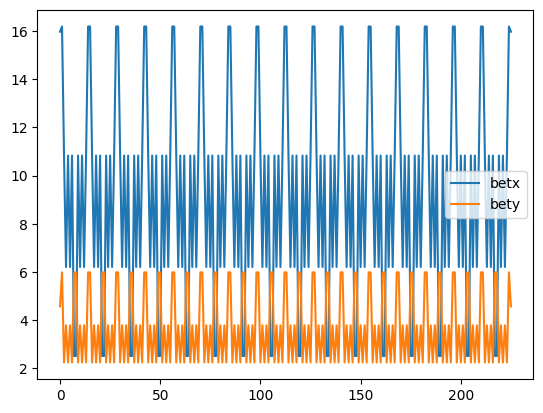

In [11]:
init_optics = get_optics(structure)
plt.plot(init_optics["betx"], label='betx')
plt.plot(init_optics["bety"], label='bety')
plt.legend()
plt.show()

## Elements and Elements with imperfections

In [12]:
elems_with_errs = [i for i in structure["elements"] if structure["elements"][i]["type"] not in ["monitor", "marker", "multipole"]]
hcorrs = {i: {"type": "hkicker"} for i in structure["elements"] if structure["elements"][i]["type"] in ["hkicker"]}
vcorrs = {i: {"type": "vkicker"} for i in structure["elements"] if structure["elements"][i]["type"] in ["vkicker"]}
corrs = {"hkicker": hcorrs, "vkicker": vcorrs}
quads = [i for i in structure["elements"] if structure["elements"][i]["type"] in ["quadrupole"]]

structure["kick"] = corrs
print(len(elems_with_errs))

1939


In [13]:
np.random.seed(42)

align_errs = {}
err_type = {"dx": 80e-6, "dy": 80e-6, "ds": 80e-6, "dpsi": 200e-6, "dphi": 200e-6, "dtheta": 200e-6}

for err in err_type:
    err_type_to_add = {err: {"Knobs": {}}}
    for elem in elems_with_errs:
        err_type_to_add[err]["Knobs"][elem] = {"Elements": [elem]}
    err_type_to_add[err]["Values"] = (np.random.normal(scale=err_type[err], size=len(elems_with_errs))).tolist()
    align_errs.update(err_type_to_add)

## Optics with imperfections

In [28]:
interim_optics = get_optics(structure, align_errs, save_etable=True, file_to_save="D:/PycharmProjects/SKIF-Lattice-Analysis/imperfections.txt")
plt.plot(interim_optics["x"], label='x')
plt.plot(interim_optics["y"], label='y')
plt.legend()
plt.show()

plt.plot(interim_optics["betx"], label='betx')
plt.plot(interim_optics["bety"], label='bety')
plt.legend()
plt.show()

Twiss Failed!


TypeError: 'NoneType' object is not subscriptable

In [32]:
# with open("D:\PycharmProjects\SKIF-Lattice-Analysis\Ring_DD_nosext.seq", "r") as f:
#     dat=f.readlines()

In [40]:
# dat1=[]
# for line in dat:
#     if "k2=" in line:
#         line1 = line.split()
#         line1[-1] = "0;"
#         dat1.append(" ".join(line1)+"\n")
#     else:
#         dat1.append(line)

# with open("D:\PycharmProjects\SKIF-Lattice-Analysis\Ring_DD_nosext1.seq", "w") as f:
#     f.writelines(dat1)